# Introduction & Outline

To start, there is two ideas going on here, one being with fake news detection, and another being text summarization. 

For the fake news classification problem, were workign with supervised learning model to predict the output of the neural nets. The data is coming from a dataset on huggingface, so its "clean" data relatively speaking.  Here it's just grabbing headlines, with the text for the article.  It's already divided into train,test, and valdiation datasets.

For the text summarization, it is a supervised machine learning problem, some methods that can work for this include text based extraction looking for what it considers a key phrase or phrases to return the most important aspects of the document.  Likewise, the data for this is merely a article about a new machine learning research project in Australia, this may be subject to change, will see. 

## Exploratory Data Analysis

_You will now load the dataset and carry out some exploratory data analysis steps to better understand what text data looks like. See the examples from class on 10/. The following links provide some good resources of exploratory analyses of text data with Python._


* https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
* https://regenerativetoday.com/exploratory-data-analysis-of-text-data-including-visualization-and-sentiment-analysis/
* https://medium.com/swlh/text-summarization-guide-exploratory-data-analysis-on-text-data-4e22ce2dd6ad  
* https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html  


The frist data set for the project I'm using is on fake news, seems like a topical subject and huggigface

In [2]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\evaluation.csv
data\test.csv
data\train.csv


In [3]:
input_data_path = 'data/'
training_data_file = 'train.csv'
df = pd.read_csv(input_data_path + training_data_file)
df.head()

,id,title,text,label
0,0.0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1.0
1,1.0,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1.0
2,2.0,FAIL! The Trump Organization�s Credit Score W...,While the controversy over Trump s personal ta...,0.0
3,3.0,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1.0
4,4.0,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0.0


In [4]:
df.describe()

,id,label
count,24338.000000,24330.000000
mean,12176.875175,0.544143
std,7032.327669,0.498058
min,0.000000,0.000000
25%,6084.250000,0.000000
50%,12183.500000,1.000000
75%,18267.750000,1.000000
max,24352.000000,1.000000


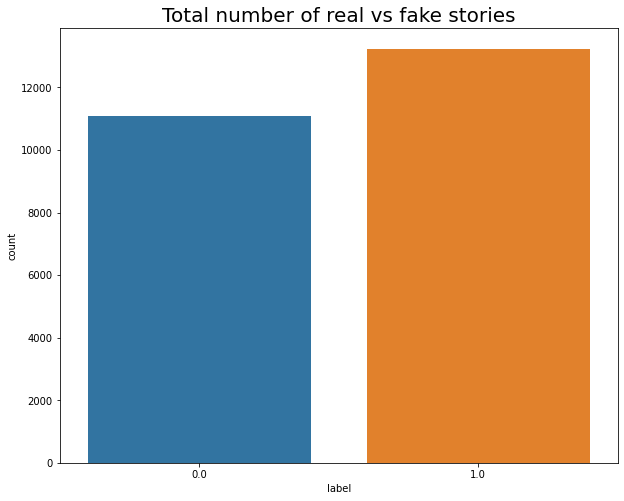

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10, 8))
ax = sns.countplot(x = df['label'], data = df)
ax.set_title(label = 'Total number of real vs fake stories', fontsize = 20)
plt.show()

# General length of text(s) and title(s)

<AxesSubplot:>

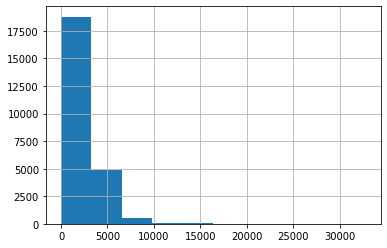

In [13]:
df['text'].str.len().hist()

<AxesSubplot:>

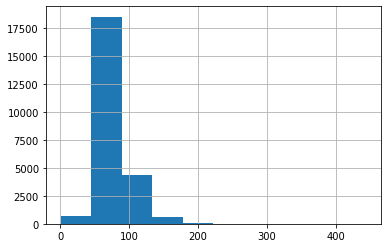

In [14]:
df['title'].str.len().hist()

In [22]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

ModuleNotFoundError: No module named 'wordcloud'

In [21]:
import sys
print(sys.executable)

c:\Users\User\AppData\Local\Programs\Python\Python39\python.exe


# Text Summarization 

switching over to the text summarization, the dataset is an article from NPR about a research group in Australia that is culturing a chip with literal neurons,
which they taught to play pong.

source: https://www.npr.org/sections/health-shots/2022/10/14/1128875298/brain-cells-neurons-learn-video-game-pong

Based on what I've seen, there's two schools of thought for text summarization: extraction based and abstraction based.  
As the name(s) imply, extraction is going for the text which we would want as its seen as "key" in the text or abstraction
which is creating a unique summary based on the given input.  I think the latter sounds more interesting, so the modeling and methods will reflect that.
However, since this webpage doesn't have the text cleanly, I'm going to cheat abit and have the entire document held in a variable "text".  


In [ ]:
summary_text = summarizer(text, max_length=100, min_length=5, do_sample=False)[0]['summary_text']
print(summary_text)